In [1]:
import matplotlib.pyplot as plt
import cyipopt as ipopt
import numpy as np

from vessel_models import VesselModel
from controller import TrajOpt

In [2]:
# Validating IPOPT
from scipy.optimize import rosen, rosen_der
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = ipopt.minimize_ipopt(rosen, x0, jac=rosen_der)
print(res)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 2.1081754165231008e-18
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00]
     nit: 37
    info:     status: 0
                   x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00
                        1.000e+00]
                   g: []
             obj_val: 2.1081754165231008e-18
              mult_g: []
            mult_x_L: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00]
      

In [3]:
# Simulation variables
N = 100
dt = 0.1
ns = 6
nu = 3

# Cost matrices
Qvec = 0.01*np.ones(ns)
Rvec = 0.01*np.ones(nu)
Qfvec = 0.1*np.ones(ns)

# Problem Definition
s0 = np.zeros(6)
sf = np.zeros(6)
sf[0] = 1
sf[1] = 1

In [4]:
model = VesselModel()
trajoptimizer = TrajOpt(model, N, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf)
trajoptimizer.exec_trajopt()

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:   543582
Number of nonzeros in inequality constraint Jacobian.:   891618
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      897
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:      994
        inequality constraints with only lower bounds:      994
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0900000e+00 1.00e+00 3.97e-01   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 4.319672360803439
       x: [ 0.000e+00  0.000e+00 ... -3.737e+00  1.559e+00]
     nit: 53
    info:     status: 0
                   x: [ 0.000e+00  0.000e+00 ... -3.737e+00  1.559e+00]
                   g: [ 6.462e-15 -5.184e-14 ...  4.677e-01  4.675e-01]
             obj_val: 4.319672360803439
              mult_g: [-4.041e+00  1.564e+00 ... -1.211e-09 -1.212e-09]
            mult_x_L: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 59
    njev: 32
4.534346408194313


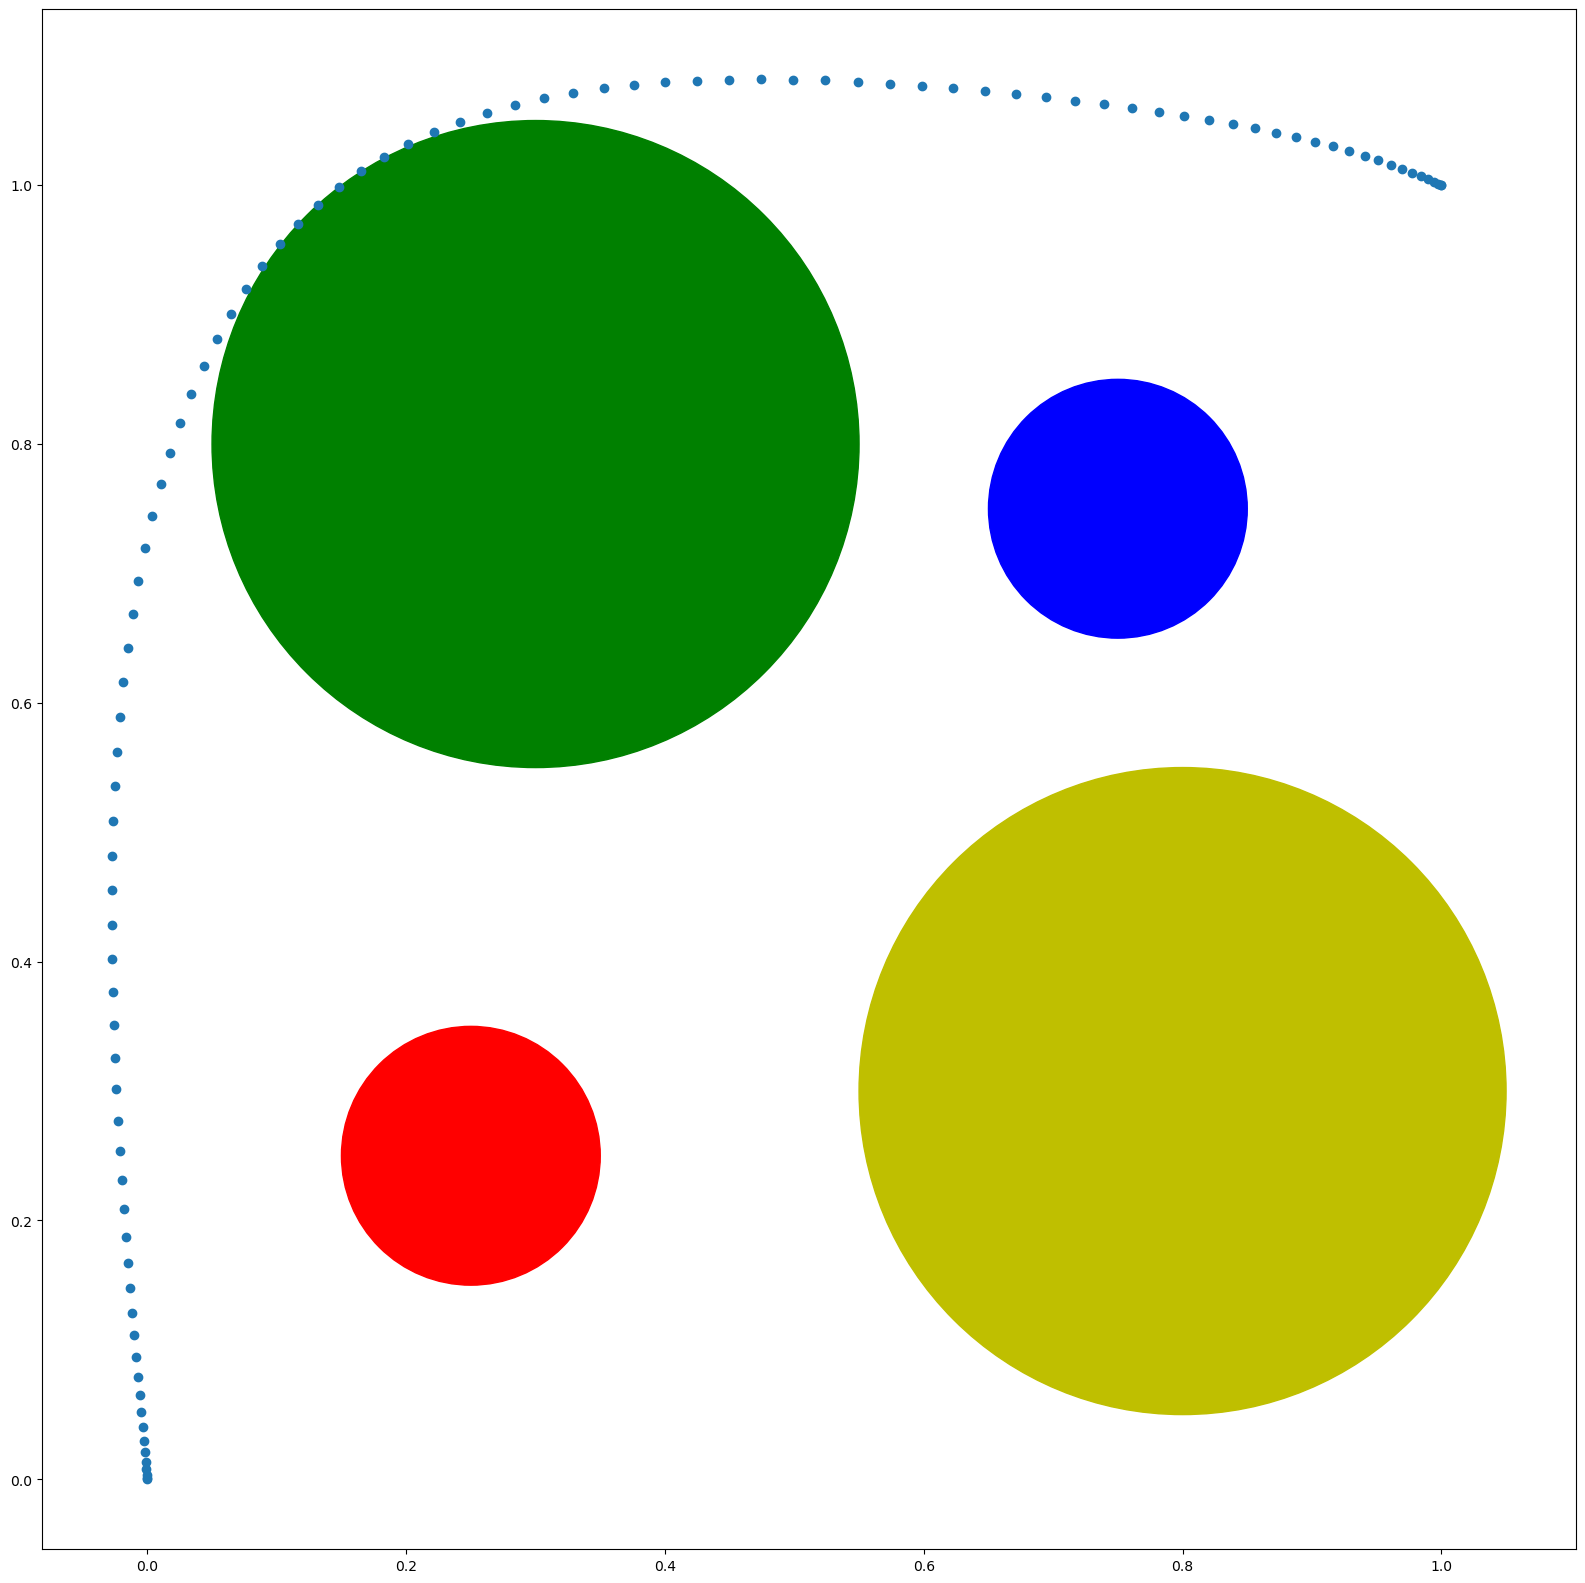

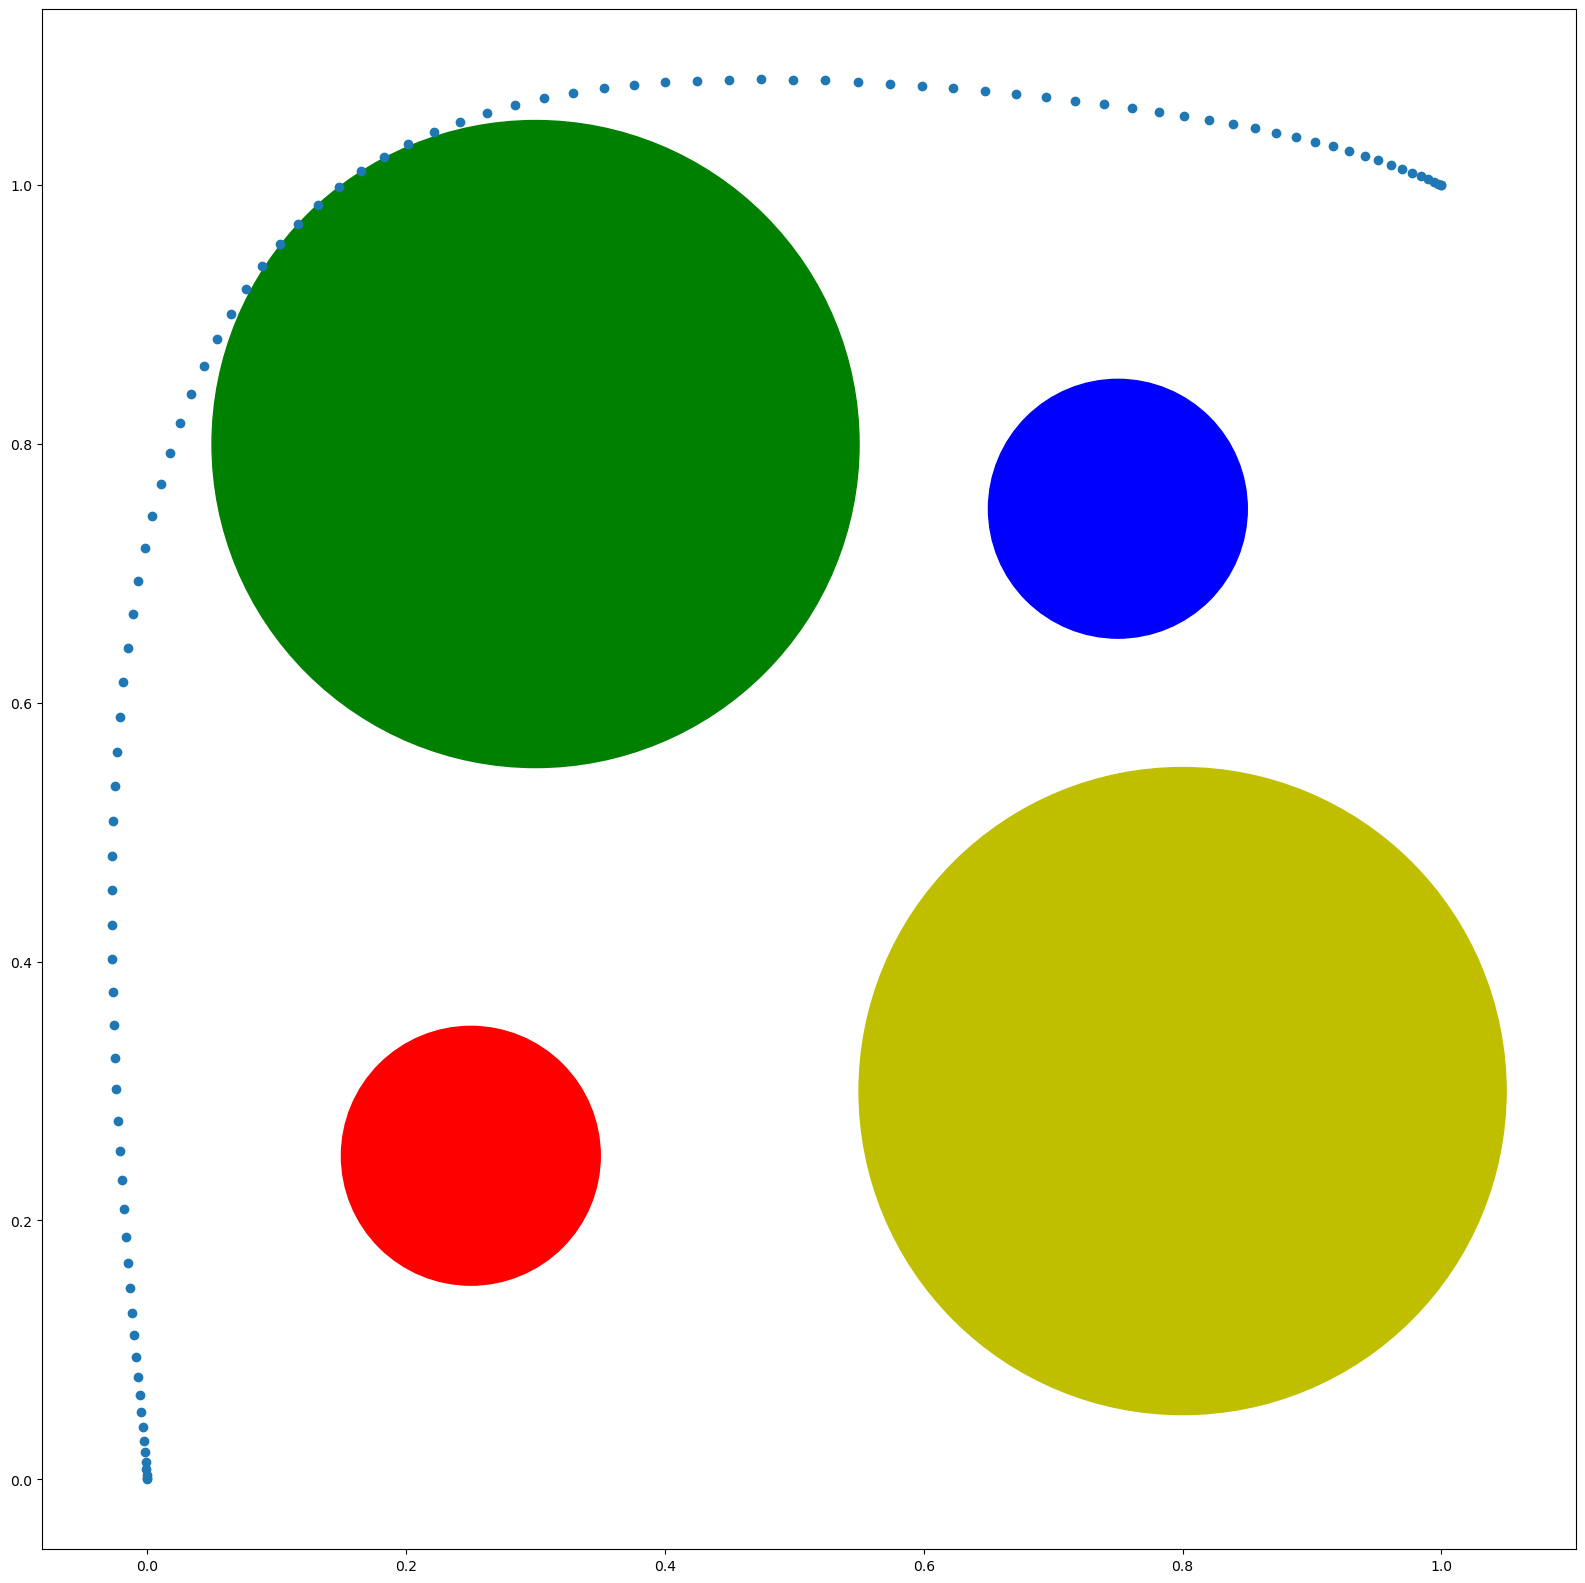

In [5]:
print(trajoptimizer.sol)
S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
print(np.max(U))
ps = S.T

np.savetxt("dircol_soln.csv", S, delimiter=",")
np.savetxt("dircol_inpu.csv", U, delimiter=",")

fig, axes = plt.subplots(1, 1, figsize=(20, 20))
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
axes.add_patch(circle2)
axes.add_patch(circle3)
axes.add_patch(circle4)
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()

Sfwd = np.zeros((N,ns))
Sfwd[0] = S[0]
for i in range(N-1):
    Sn = Sfwd[i]
    Un = U[i]
    Sfwd[i+1] = model.rk4(Sn, Un, dt)

ps = Sfwd.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
axes.add_patch(circle2)
axes.add_patch(circle3)
axes.add_patch(circle4)
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()

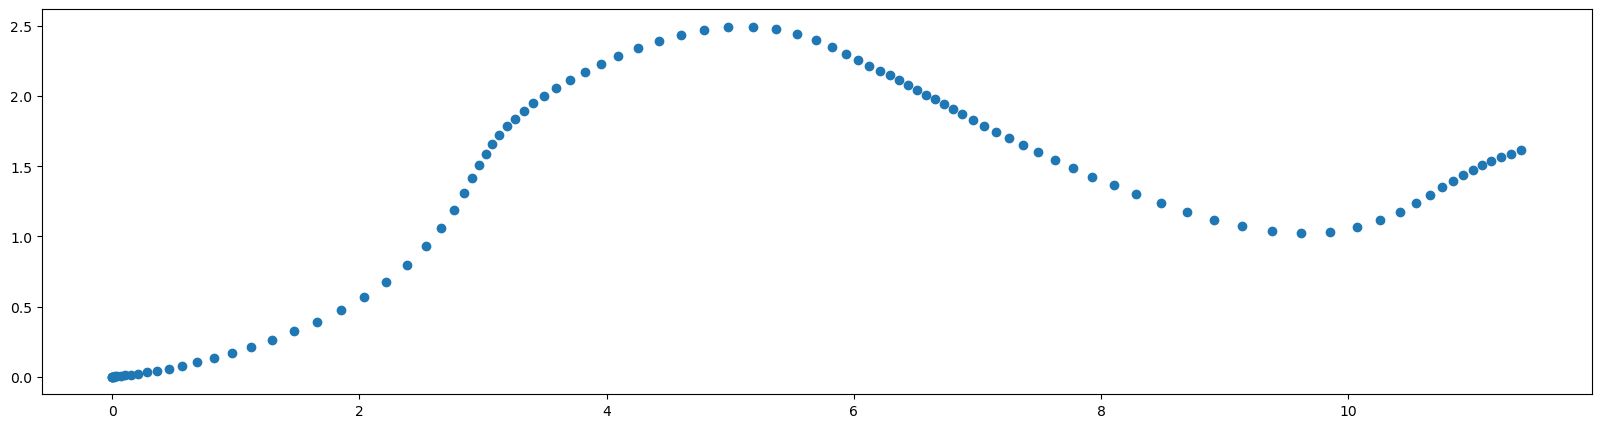

In [6]:
Sn = np.zeros(6)
Un = np.zeros(3)
Un[0] = 5
Un[1] = 5

S = np.zeros((N, ns))
S[0] = Sn

U = np.zeros((N-1, nu))
for i in range(N-1):
    U[i] = [40*np.sin(dt*i),np.cos(dt*i),np.cos(dt*i)]

for i in range(N-1):
    S[i+1] = model.rk4(S[i], U[i], dt)

ps = list(zip(*S))
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
axes.scatter(ps[0], ps[1])
plt.show()